<a href="https://colab.research.google.com/github/AnitaKirkovska/Machine_Learning_Class/blob/master/HW3/VGG19_Data_Aug_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  

--2019-04-17 12:18:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   214MB/s    in 0.3s    

2019-04-17 12:18:13 (214 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

**VGG 19**

In [4]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
conv_base.trainable = False

**Merge**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# no dropout
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


**Training**

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 23s 226ms/step - loss: 0.6134 - acc: 0.6775 - val_loss: 0.4927 - val_acc: 0.7860
Epoch 2/30
100/100 [==============================] - 18s 177ms/step - loss: 0.5329 - acc: 0.7480 - val_loss: 0.4203 - val_acc: 0.8180
Epoch 3/30
100/100 [==============================] - 18s 177ms/step - loss: 0.4784 - acc: 0.7785 - val_loss: 0.3735 - val_acc: 0.8360
Epoch 4/30
100/100 [==============================] - 19s 192ms/step - loss: 0.4440 - acc: 0.8040 - val_loss: 0.3578 - val_acc: 0.8460
Epoch 5/30
100/100 [==============================] - 18s 178ms/step - loss: 0.4286 - acc: 0.8030 - val_loss: 0.3336 - val_acc: 0.8500
Epoch 6/30
100/100 [==============================] - 19s 192ms/step - loss: 0.4208 - acc: 0.8060 - val_loss: 0.3313 - val_acc: 0.8630
Epoch 7/30
100/100 [==============================] - 18s 

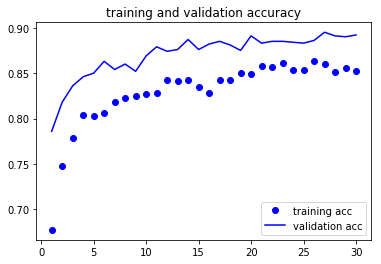

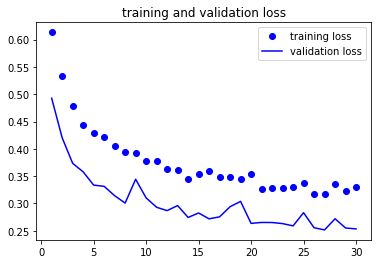

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Fine tuning**

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv4':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 198ms/step - loss: 0.3119 - acc: 0.8615 - val_loss: 0.2393 - val_acc: 0.8950
Epoch 2/100
100/100 [==============================] - 18s 179ms/step - loss: 0.3150 - acc: 0.8640 - val_loss: 0.2808 - val_acc: 0.8820
Epoch 3/100
100/100 [==============================] - 19s 188ms/step - loss: 0.3162 - acc: 0.8580 - val_loss: 0.2683 - val_acc: 0.8950
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 0.2985 - acc: 0.8655 - val_loss: 0.2431 - val_acc: 0.8960
Epoch 5/100
100/100 [==============================] - 18s 181ms/step - loss: 0.3061 - acc: 0.8705 - val_loss: 0.2712 - val_acc: 0.8890
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 0.2763 - acc: 0.8800 - val_loss: 0.2126 - val_acc: 0.9130
Epoch 7/100
100/100 [==============================] - 18s 178ms/step - loss: 0.2741 - acc: 0.8800 - val_loss: 0.2365 - val_acc: 0.8910
Epoch 8/100
100/100 [===========================

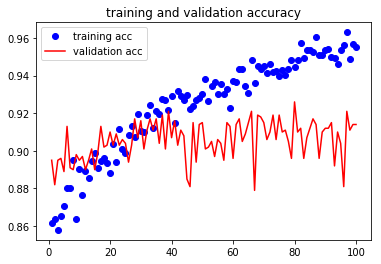

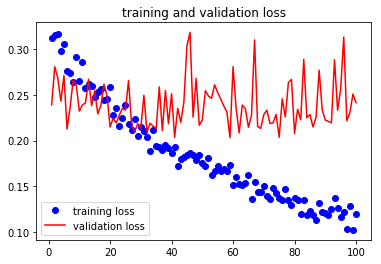

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [16]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.23247014604508875
Validation accuracy: 0.9139999926090241


**Saving model**

In [0]:
model_fname = 'cats_and_dogs_fine_1.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)